_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 3

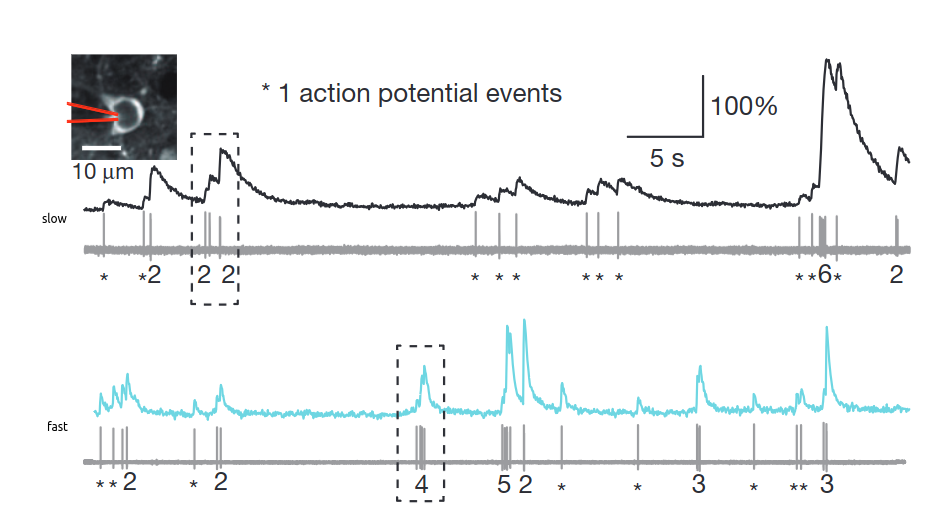

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-08 17:03:15CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

sklearn: 1.6.1

scipy     : 1.15.2
seaborn   : 0.13.2
numpy     : 2.0.1
matplotlib: 3.10.0
pandas    : 2.2.3

Watermark: 2.5.0



In [7]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [8]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# spike dataframe
ogb_spikes.head()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

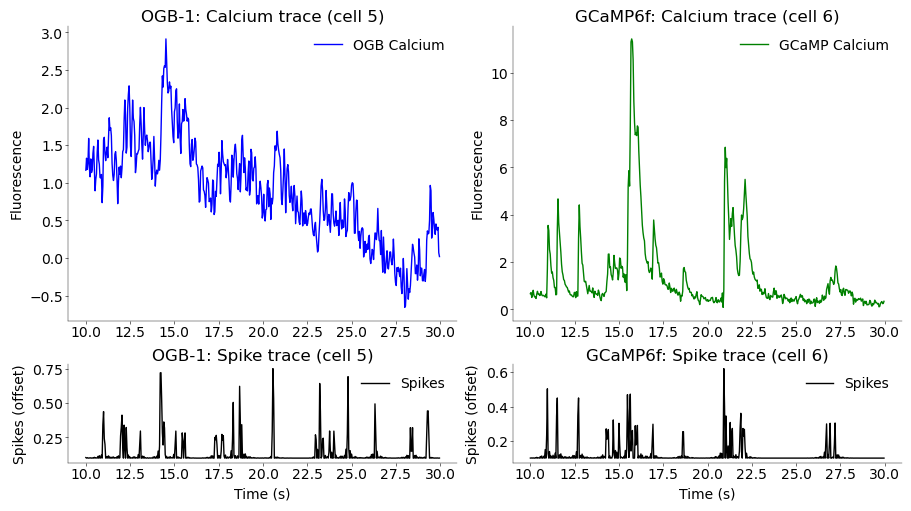

In [9]:
# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------
import pandas as pd
from scipy.signal import decimate

decimate_factor = 4  # because 100/25
ogb_calcium_resampled = ogb_calcium.apply(
    lambda col: decimate(col, decimate_factor), axis=0
)
ogb_spikes_resampled = ogb_spikes.apply(
    lambda col: decimate(col, decimate_factor), axis=0
)

gcamp_calcium_resampled = gcamp_calcium.apply(
    lambda col: decimate(col, decimate_factor), axis=0
)
gcamp_spikes_resampled = gcamp_spikes.apply(
    lambda col: decimate(col, decimate_factor), axis=0
)

ogb_calcium_resampled = pd.DataFrame(
    ogb_calcium_resampled.values, columns=ogb_calcium.columns
)
ogb_spikes_resampled = pd.DataFrame(
    ogb_spikes_resampled.values, columns=ogb_spikes.columns
)
gcamp_calcium_resampled = pd.DataFrame(
    gcamp_calcium_resampled.values, columns=gcamp_calcium.columns
)
gcamp_spikes_resampled = pd.DataFrame(
    gcamp_spikes_resampled.values, columns=gcamp_spikes.columns
)


fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)

# start and end in seconds?
start_t = 10
end_t = 30
sampling_rate = 25
start_index = start_t * sampling_rate
end_index = end_t * sampling_rate

ogb_cell = 5
gcamp_cell = 6

# Extract calcium and spike data (already resampled!)
ogb_cal = ogb_calcium_resampled.iloc[start_index:end_index, ogb_cell]
ogb_spk = ogb_spikes_resampled.iloc[start_index:end_index, ogb_cell].clip(lower=0)

gcamp_cal = gcamp_calcium_resampled.iloc[start_index:end_index, gcamp_cell]
gcamp_spk = gcamp_spikes_resampled.iloc[start_index:end_index, gcamp_cell].clip(lower=0)


time = np.arange(start_index, end_index) / sampling_rate


# --------------------
# Plot OGB data (1 pt)
# --------------------

axs[0, 0].plot(time, ogb_cal, label="OGB Calcium", color="blue")
axs[0, 0].set_title("OGB-1: Calcium trace (cell 5)")
axs[0, 0].set_ylabel("Fluorescence")
axs[0, 0].legend()

axs[1, 0].plot(time, ogb_spk + 0.1, label="Spikes", color="black")  # Offset spike trace
axs[1, 0].set_title("OGB-1: Spike trace (cell 5)")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Spikes (offset)")
axs[1, 0].legend()


# ----------------------
# Plot GCamp data (1 pt)
# ----------------------

axs[0, 1].plot(time, gcamp_cal, label="GCaMP Calcium", color="green")
axs[0, 1].set_title("GCaMP6f: Calcium trace (cell 6)")
axs[0, 1].set_ylabel("Fluorescence")
axs[0, 1].legend()

axs[1, 1].plot(
    time, gcamp_spk + 0.1, label="Spikes", color="black"
)  # Offset spike trace
axs[1, 1].set_title("GCaMP6f: Spike trace (cell 6)")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Spikes (offset)")
axs[1, 1].legend()

plt.show()

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

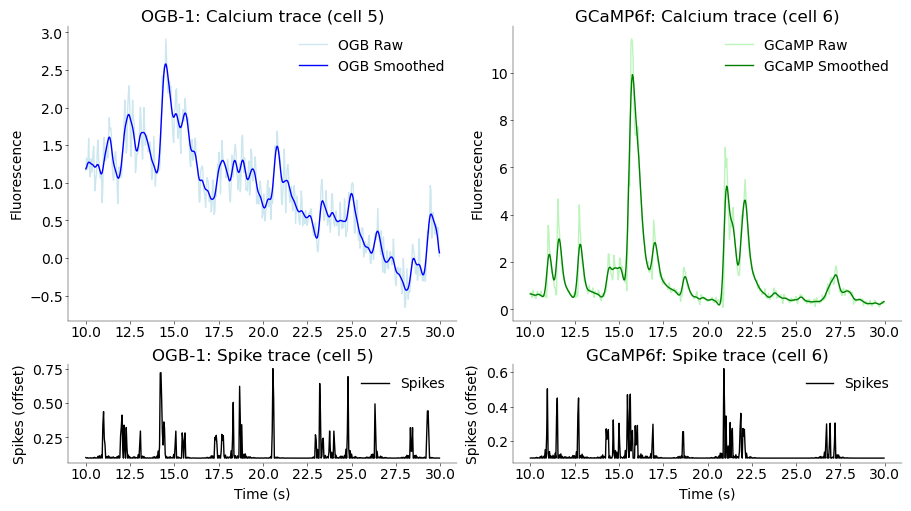

In [ ]:
from scipy.signal import butter, filtfilt


# only lowpass, because calcium signals are moving slowly, compared to what we did in task 1
# But we also use a butterworth filter
def lowpass_filter(data, cutoff=2.0, fs=25.0, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return filtfilt(b, a, data)


def moving_average(data, window_size=3):
    return data.rolling(window=window_size, center=True, min_periods=1).mean()


# Example on OGB calcium trace:
ogb_cal_smoothed = pd.Series(lowpass_filter(ogb_cal)).pipe(
    moving_average, window_size=3
)
gcamp_cal_smoothed = pd.Series(lowpass_filter(gcamp_cal)).pipe(
    moving_average, window_size=3
)

fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)

# Time is already defined:
# time = np.arange(start_index, end_index) / sampling_rate

# Plot OGB data

axs[0, 0].plot(time, ogb_cal, label="OGB Raw", color="lightblue", alpha=0.6)
axs[0, 0].plot(time, ogb_cal_smoothed, label="OGB Smoothed", color="blue")
axs[0, 0].set_title("OGB-1: Calcium trace (cell 5)")
axs[0, 0].set_ylabel("Fluorescence")
axs[0, 0].legend()

axs[1, 0].plot(time, ogb_spk + 0.1, label="Spikes", color="black")
axs[1, 0].set_title("OGB-1: Spike trace (cell 5)")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Spikes (offset)")
axs[1, 0].legend()


# Plot GCaMP data (1 pt)

axs[0, 1].plot(time, gcamp_cal, label="GCaMP Raw", color="lightgreen", alpha=0.6)
axs[0, 1].plot(time, gcamp_cal_smoothed, label="GCaMP Smoothed", color="green")
axs[0, 1].set_title("GCaMP6f: Calcium trace (cell 6)")
axs[0, 1].set_ylabel("Fluorescence")
axs[0, 1].legend()

axs[1, 1].plot(time, gcamp_spk + 0.1, label="Spikes", color="black")
axs[1, 1].set_title("GCaMP6f: Spike trace (cell 6)")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Spikes (offset)")
axs[1, 1].legend()

plt.show()

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [18]:
from scipy.signal import lfilter
from scipy.signal import deconvolve


def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------
    """
    alpha = np.exp(-dt / tau)  # decay factor
    b = [1]  # numerator (input stays as-is)
    a = [1, -alpha]  # denominator (models decay)

    # Apply inverse filter
    sp_hat = lfilter(b, a, ca)

    # No negative firing rates
    sp_hat = np.clip(sp_hat, 0, None)

    return sp_hat
    """
    # Create exponential decay kernel
    n_points = len(ca)
    t = np.arange(n_points) * dt
    kernel = np.exp(-t / tau)

    # Normalize kernel (optional)
    kernel /= kernel.sum()

    # Perform deconvolution
    _, sp_hat = deconvolve(ca, kernel)

    print(sp_hat.shape)

    # Clip negative values
    sp_hat = np.clip(sp_hat, 0, None)

    return sp_hat

C:\Users\andre\AppData\Local\Temp\ipykernel_37556\3337998861.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


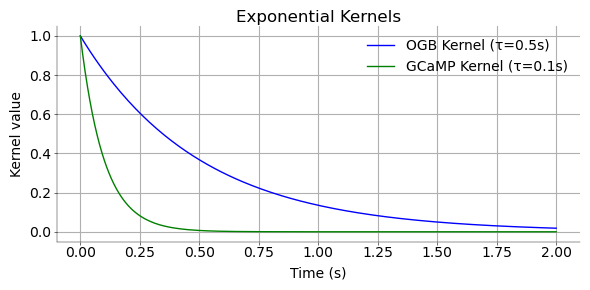

C:\Users\andre\AppData\Local\Temp\ipykernel_37556\3337998861.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(2500,)


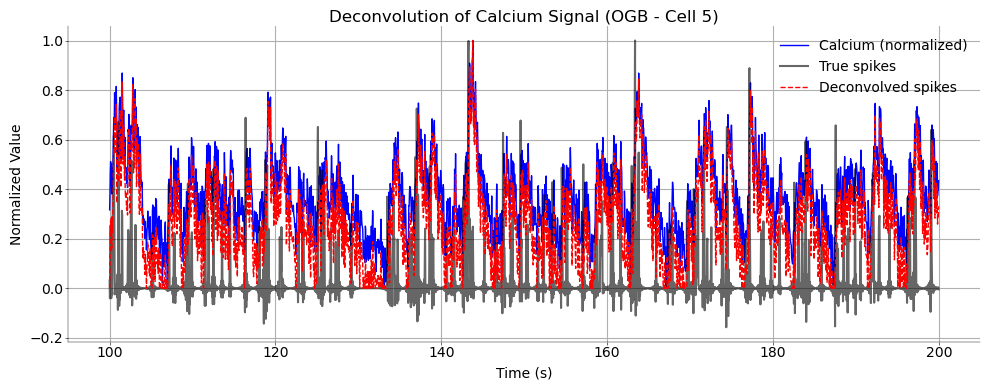

In [ ]:
# Parameters
tau_ogb = 0.5
tau_gcamp = 0.1
sampling_rate = 25  # Hz
dt = 1 / sampling_rate

# 1. Plot the exponential kernels
t_kernel = np.linspace(0, 2, 200)
kernel_ogb = np.exp(-t_kernel / tau_ogb)
kernel_gcamp = np.exp(-t_kernel / tau_gcamp)

plt.figure(figsize=(6, 3))
plt.plot(t_kernel, kernel_ogb, label="OGB Kernel (τ=0.5s)", color="blue")
plt.plot(t_kernel, kernel_gcamp, label="GCaMP Kernel (τ=0.1s)", color="green")
plt.title("Exponential Kernels")
plt.xlabel("Time (s)")
plt.ylabel("Kernel value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Pick example cell (like in Task 1)
cell_idx = 5  # OGB example
start_t = 20
end_t = 30
start_idx = int(start_t * sampling_rate)
end_idx = int(end_t * sampling_rate)
time = np.arange(start_idx, end_idx) / sampling_rate

# Use resampled data from Task 1
ca = ogb_calcium_resampled.iloc[start_idx:end_idx, cell_idx].values
true_spikes = ogb_spikes_resampled.iloc[start_idx:end_idx, cell_idx].values

# 3. Run deconvolution
sp_hat = deconv_ca(ca, tau=tau_ogb, dt=dt)

# Normalize everything for visual comparison
ca_norm = (ca - ca.min()) / (ca.max() - ca.min())
sp_hat_norm = sp_hat / sp_hat.max()
true_spikes_norm = true_spikes / (true_spikes.max() + 1e-5)

# 4. Plot everything
plt.figure(figsize=(10, 4))
plt.plot(time, ca_norm, label="Calcium (normalized)", color="blue")
plt.plot(
    time, true_spikes_norm, label="True spikes", color="black", linewidth=1.5, alpha=0.6
)
plt.plot(time, sp_hat_norm, label="Deconvolved spikes", color="red", linestyle="--")
plt.title("Deconvolution of Calcium Signal (OGB - Cell 5)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

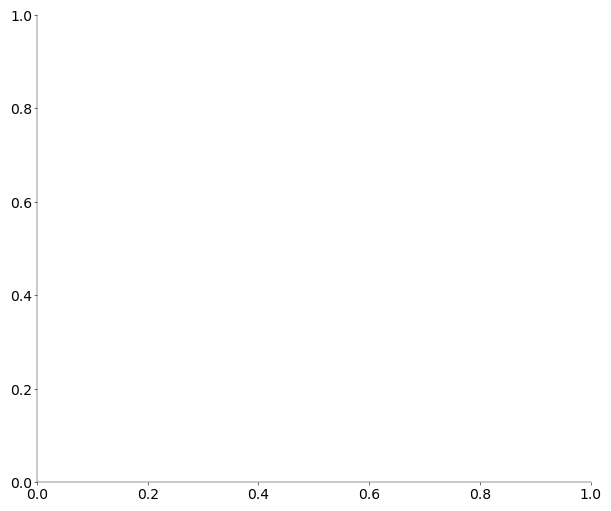

In [8]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

### Questions (1 pt)
1) Explain how you constructed the kernels

YOUR ANSWER HERE

2) How do the indicators / kernels compare?

YOUR ANSWER HERE

3) What are pros and cons of each indicator?

YOUR ANSWER HERE

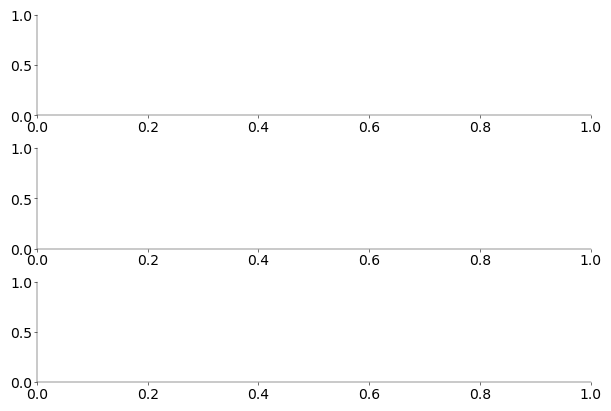

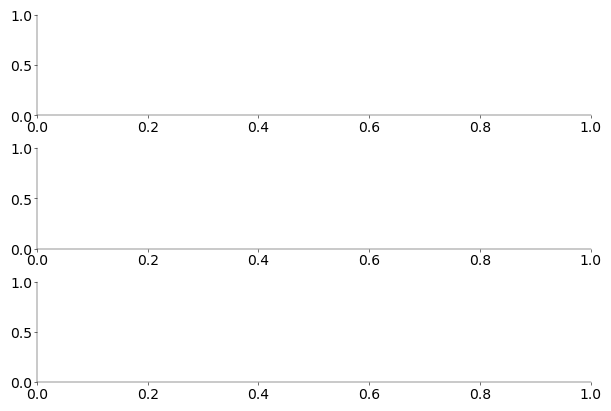

In [9]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamp Cell

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [10]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


ModuleNotFoundError: No module named 'oopsi'

In [ ]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------

In [ ]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations
import logging
import scipy.signal

sns.set_theme(style="whitegrid")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [79]:
def init_config():
    """Initialize the configuration for the analysis."""
    config = {
        "sampling_rate": 100,
        "new_sampling_rate": 25,
        "decimate_factor": 4,
        "start_time": 10,
        "end_time": 30,
        "tau_ogb": 0.5,
        "tau_gcamp": 0.1,
        "cell_ogb": 5,
        "cell_gcamp": 6,
        "deconvolution_plot_start_time": 0, 
        "deconvolution_plot_end_time": 140
    }
    # Downsample factor: 100 Hz → 25 Hz → factor = 4
    config["downsample_factor"] = config["sampling_rate"] // config["new_sampling_rate"]
    config["dt"] = 1 / config["new_sampling_rate"]  # 0.04 s
    
    # plotting timestamps:
    config["deconvolution_plot_start_index"] = int(config["deconvolution_plot_start_time"] * config["new_sampling_rate"])
    config["deconvolution_plot_end_index"] = int(config["deconvolution_plot_end_time"] * config["new_sampling_rate"])
    start = config["deconvolution_plot_start_index"]
    end = config["deconvolution_plot_end_index"]
    
    config["deconvolution_plot_time_segment"]= np.arange(start, end) / config["new_sampling_rate"] # Absolute time
    return config

config = init_config()

In [80]:
# %%
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
logging.debug(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
logging.debug(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")


In [81]:
#%% Resample the spikes
def bin_spikes(spike_array, factor: int) -> np.ndarray:
    """Downsample spikes by summing over non-overlapping bins.

    Parameters
    ----------
    spike_df : pd.DataFrame
        Original spike data at high resolution (100 Hz).
    factor : int
        Downsampling factor (e.g. 4 for 100 Hz -> 25 Hz).

    Returns
    -------
    np.ndarray
        Binned spike matrix (n_bins, n_cells).
    """
    logging.debug(f"Original shape: {spike_array.shape}")
    # spike_array = spike_df.iloc[:, 1:].values  # Drop time/index column if present
    n_bins = spike_array.shape[0] // factor
    n_cells = spike_array.shape[1]
    spike_array = spike_array[:n_bins * factor]  # Trim to full bins
    binned = spike_array.reshape(n_bins, factor, n_cells).sum(axis=1)
    return binned

In [77]:
# Resample the data
resampled_ogb_calcium = scipy.signal.decimate(
    ogb_calcium.iloc[:, 1:].values, config["downsample_factor"], axis=0
)

resampled_gcamp_calcium = scipy.signal.decimate(
    gcamp_calcium.iloc[:, 1:].values, config["downsample_factor"], axis=0
)

#%%

# Binned spike arrays
resampled_ogb_spikes = bin_spikes(ogb_spikes.iloc[:,1:].values, config["downsample_factor"])
resampled_gcamp_spikes = bin_spikes(gcamp_spikes.iloc[:, 1:].values, config["downsample_factor"])

# Check shape
logging.debug(f"Binned OGB spikes shape: {resampled_ogb_spikes.shape}")
logging.debug(f"Binned GCaMP spikes shape: {resampled_gcamp_spikes.shape}")



In [30]:
tau_ogb = 0.5
tau_gcamp = 0.1


In [78]:
#%%
def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
    """
    # --------------------------------------------
    # Apply de-convolution to calcium signal (1 pt)
    # --------------------------------------------
    # Define kernel duration to cover 5*tau
    kernel_len = int(np.ceil(5 * tau / dt))
    t = np.arange(kernel_len) * dt
    
    # Create exponential decay kernel
    kernel = np.exp(-t / tau)
    
    # Normalize kernel to have unit area
    kernel /= kernel.sum()
    
    # Use scipy to deconvolve
    sp_hat, _ = signal.deconvolve(ca, kernel)

    # Pad the output to match original size (deconvolve returns shorter output)
    sp_hat = np.pad(sp_hat, (0, ca.shape[0] - sp_hat.shape[0]), mode="constant")

    # Clip negative values
    sp_hat = np.clip(sp_hat, 0, None)
    
    return sp_hat

In [46]:
def plot_deconvolution_results_comparison(
    calcium_trace_segment: np.ndarray,
    true_spikes_segment: np.ndarray,
    time_points: np.ndarray,
    tau_value: float,
    dt_value: float,
    deconvolution_function: callable,
    plot_title: str,
    save_filename: str = None,
    figsize: tuple = (8, 5)
):
    """
    Performs deconvolution on a calcium segment and plots the calcium trace,
    deconvolved spikes, and true spikes.

    Parameters:
    ----------
    calcium_trace_segment : np.ndarray
        The segment of the calcium trace for a single cell.
    true_spikes_segment : np.ndarray
        The corresponding segment of the true spike data.
    time_points : np.ndarray
        An array of time points for the x-axis, corresponding to the segments' duration.
    tau_value : float
        The decay constant (tau) for the deconvolution kernel.
    dt_value : float
        The sampling interval (dt) of the data.
    deconvolution_function : callable
        The function to use for deconvolution (e.g., the `deconv_ca` function).
        It should accept arguments like (calcium_trace, tau, dt) and
        return the deconvolved spike estimates.
    plot_title : str
        The main title for the plot.
    save_filename : str, optional
        The full path and filename (e.g., "../plots/gcamp_deconv.png")
        to save the figure. If None, the plot is displayed but not saved.
    figsize : tuple, optional
        The size of the figure (width, height) in inches.
    """

    # Perform deconvolution using the provided function
    sp_hat_segment = deconvolution_function(calcium_trace_segment, tau=tau_value, dt=dt_value)

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=figsize, sharex=True)

    # Plot 1: Calcium Trace
    axs[0].plot(time_points, calcium_trace_segment, label="Calcium")
    axs[0].set_ylabel("Ca")  # Original Y-label from your snippet
    axs[0].legend()

    # Plot 2: Deconvolved Spikes
    axs[1].plot(time_points, sp_hat_segment, label="Deconv. spikes", color="green")
    axs[1].set_ylabel("Deconv")  # Original Y-label
    axs[1].legend()

    # Plot 3: True Spikes
    axs[2].plot(time_points, true_spikes_segment, label="True spikes", color="orange", alpha=0.6)
    axs[2].set_ylabel("True")  # Original Y-label
    axs[2].set_xlabel("Time (s)")
    axs[2].legend()

    # Set the overall title for the figure
    fig.suptitle(plot_title)

    # Apply tight layout to adjust plot parameters for a tight layout.
    # rect is [left, bottom, right, top] in figure coordinates, making space for suptitle.
    fig.tight_layout(rect=[0, 0, 1, 0.96])


    # Save the figure if a path is provided
    if save_filename:
        plt.savefig(save_filename, dpi=300)
        print(f"Plot saved to {save_filename}")

    plt.show()

In [ ]:
new_sampling_rate = 25 # Hz
start = 1000
end = start + 100 * new_sampling_rate # Or however long your segment is
dt = 1 / new_sampling_rate # Sampling interval

Plot saved to ../plots/ogb_deconv_cell5.png


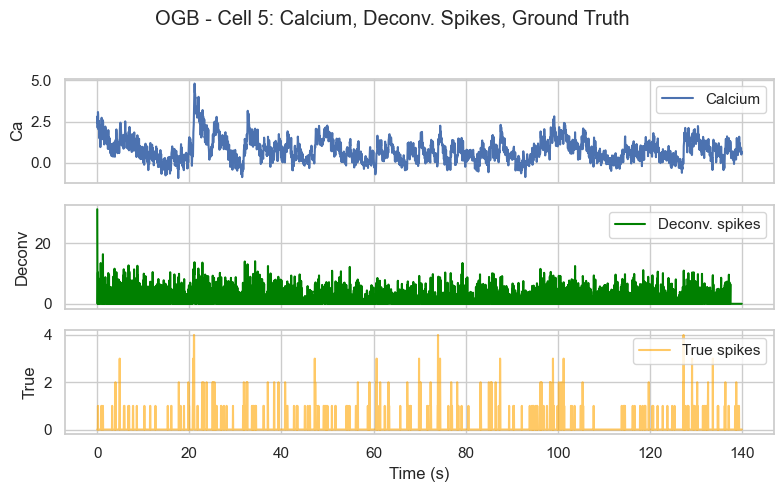

In [82]:
#%%
# Plotting
cell_ogb = 5
ca_ogb_segment = resampled_ogb_calcium[config["deconvolution_plot_start_index"]:config["deconvolution_plot_end_index"], cell_ogb]
true_spikes_ogb_segment = resampled_ogb_spikes[config["deconvolution_plot_start_index"]:config["deconvolution_plot_end_index"], cell_ogb]

plot_deconvolution_results_comparison(
    calcium_trace_segment=ca_ogb_segment,
    true_spikes_segment=true_spikes_ogb_segment,
    time_points=config["deconvolution_plot_time_segment"],
    tau_value=config["tau_ogb"],
    dt_value=config["dt"],
    deconvolution_function=deconv_ca,
    plot_title="OGB - Cell 5: Calcium, Deconv. Spikes, Ground Truth",
    save_filename="../plots/ogb_deconv_cell5.png"
)

Plot saved to ../plots/gcamp_deconv_cell6_standalone.png


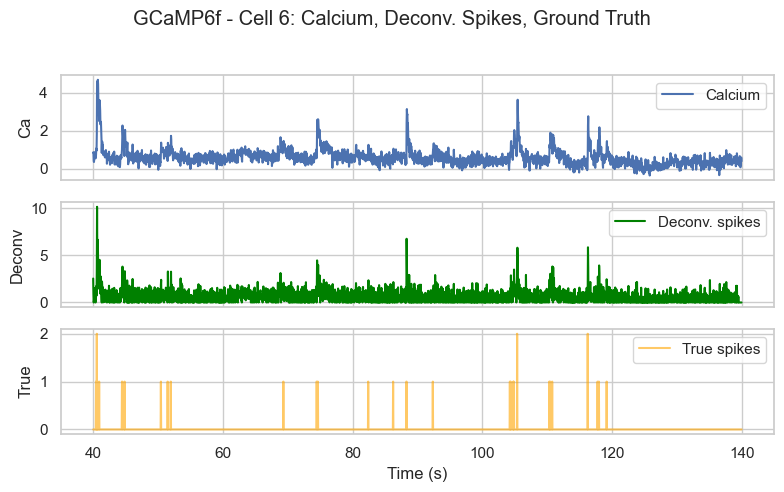

In [83]:
# --- Assumed variables from your notebook's context for GCaMP Cell 6 ---
cell_gcamp_id = 6 # Or some identifier for the cell

tau_gcamp = 0.1 # seconds for GCaMP

# Sliced data segments for the chosen cell and window
ca_gcamp_segment = resampled_gcamp_calcium[start:end, cell_gcamp_id]
true_spikes_gcamp_segment = resampled_gcamp_spikes[start:end, cell_gcamp_id]

# Time vector for the x-axis
time_gcamp_segment = np.arange(start, end) / new_sampling_rate # Absolute time
# OR, if you prefer time relative to segment start:
# time_gcamp_segment_relative = np.arange(len(ca_gcamp_segment)) * dt

# --- Example Call to the new function ---
plot_deconvolution_results_comparison(
    calcium_trace_segment=ca_gcamp_segment,
    true_spikes_segment=true_spikes_gcamp_segment,
    time_points=time_gcamp_segment, # Use the appropriate time vector
    tau_value=tau_gcamp,
    dt_value=dt,
    deconvolution_function=deconv_ca, # Pass the actual function object
    plot_title=f"GCaMP6f - Cell {cell_gcamp_id}: Calcium, Deconv. Spikes, Ground Truth",
    save_filename="../plots/gcamp_deconv_cell6_standalone.png"
)

In [32]:
def run_deconvolution(calcium: np.ndarray, 
                      tau: float, 
                      dt: float) -> np.ndarray:
    """
    Run deconvolution on calcium data for all cells.

    Parameters
    ----------
    calcium : np.ndarray
        Calcium data of shape (time, n_cells).
    tau : float
        Decay constant for the algorithm.
    dt : float
        Sampling interval.

    Returns
    -------
    np.ndarray
        Inferred spike data of shape (time, n_cells).
    """
    inferred_spikes = np.zeros_like(calcium)
    for cell in range(calcium.shape[1]):  # Iterate over each cell
        inferred_spikes[:, cell] = deconv_ca(calcium[:, cell], tau=tau, dt=dt)
    return inferred_spikes

In [33]:
def evaluate_algorithm(
    algorithm: str,
    calcium: np.ndarray,
    spikes: np.ndarray,
    tau: float,
    dt: float,
    indicator: str  # Add this to label which dataset (OGB or GCaMP)
) -> pd.DataFrame:
    """
    Evaluate the algorithm on calcium and spike data for all 
    cells.

    Parameters
    ----------
    calcium : np.ndarray
        Calcium data of shape (time, n_cells).
    spikes : np.ndarray
        Binned spike data of shape (time, n_cells).
    algorithm : str
        Algorithm to use ("deconv" or "oopsi").
    tau : float
        Decay constant for the algorithm.
    dt : float
        Sampling interval.
    indicator : str
        Indicator label (e.g. "OGB" or "GCaMP").

    Returns
    -------
    pd.DataFrame
        DataFrame with correlation results for each cell.
    """
    # Run the algorithm
    if algorithm == "deconv":
        inferred_spikes = run_deconvolution(calcium, tau=tau, dt=dt)
    elif algorithm == "oopsi":
        raise ValueError(f"Unsupported algorithm: {algorithm}")
    else:
        raise ValueError(f"Unsupported algorithm: {algorithm}")
    
    # Ensure same shape
    assert inferred_spikes.shape == spikes.shape, \
        f"Shape mismatch: inferred {inferred_spikes.shape}, true {spikes.shape}"
    
    # Compute correlation for each cell
    results = []
    for cell in range(spikes.shape[1]):
        true_cell = spikes[:, cell]
        inferred_cell = inferred_spikes[:, cell]

        # Optional: handle NaNs if any
        if np.isnan(true_cell).any() or np.isnan(inferred_cell).any():
            corr = np.nan
        else:
            corr = np.corrcoef(true_cell, inferred_cell)[0, 1]

        results.append({
            "algorithm": algorithm,
            "correlation": corr,
            "indicator": indicator,
            "cell": cell
        })

    return pd.DataFrame(results)

In [34]:
def run_all_algorithms(
    indicators: list[str],
    calcium_data_map: dict,
    spike_data_map: dict, 
    algorithm_map: dict,
    tau_map: dict,
    dt: float,
) -> pd.DataFrame:
    """
    Run all algorithms on the provided calcium and spike data.
    Parameters
    ----------
    indicators : list[str]
        List of indicators (e.g. ["OGB", "GCaMP"]).
    calcium_data : dict
        Dictionary mapping indicator names to their respective calcium data.
    spike_data : dict 
        Dictionary mapping indicator names to their respective spike data. 
    algorithm_map : dict
        Mapping of algorithm names to their respective functions.
    tau_map : dict 
        Mapping of indicator names to their respective tau values.
    dt : float
        Sampling interval.
    Returns
    -------
    pd.DataFrame
        DataFrame with correlation results for each cell.
    """
    # List to store individual DataFrame results
    all_results_list = []

    for alg_name, alg_func in algorithm_map.items():
        for indicator in indicators:
            # Get the calcium and spike data for the current indicator
            calcium_data = calcium_data_map[indicator]
            spike_data = spike_data_map[indicator]
            tau = tau_map[indicator]
            
            logging.debug(f"\nEvaluating Algorithms: '{alg_name}' for Indicator: '{indicator}'")
            logging.debug(f"Initial calcium data shape: {calcium_data.shape}")
            logging.debug(f"Initial spike data shape: {spike_data.shape}")
            # Ensure calcium and spike data have the same number of time points (rows)
            # This can be important if decimation and binning led to slight length differences  
            min_rows = min(calcium_data.shape[0], spike_data.shape[0])
            aligned_calcium = calcium_data[:min_rows, :]
            aligned_spikes = spike_data[:min_rows, :]
            logging.debug(f"Aligned calcium shape for evaluation: {aligned_calcium.shape}")
            logging.debug(f"Aligned spikes shape for evaluation: {aligned_spikes.shape}")
            
            # Call the evaluation function
            df_result = evaluate_algorithm(
                algorithm=alg_name,
                calcium=aligned_calcium,
                spikes=aligned_spikes,
                tau=tau,
                dt=dt,
                indicator=indicator
            )
            all_results_list.append(df_result)
    # Concatenate all results into the final DataFrame  
    if all_results_list:
        eval_results_df = pd.concat(all_results_list, ignore_index=True)
    else:
        eval_results_df = pd.DataFrame() # Create an empty DataFrame if no results
    return eval_results_df

In [84]:
#%%
eval_results_df = run_all_algorithms(
    indicators=["OGB", "GCaMP"],
    calcium_data_map={
        "OGB": resampled_ogb_calcium,
        "GCaMP": resampled_gcamp_calcium
    },
    spike_data_map={
        "OGB": resampled_ogb_spikes,
        "GCaMP": resampled_gcamp_spikes
    },
    algorithm_map={
        "deconv": run_deconvolution,
        # TODO: Add "oopsi": oopsi.oopsi if you implement it
    },
    tau_map={
        "OGB": config["tau_ogb"],
        "GCaMP": config["tau_gcamp"]
    },
    dt=dt
)
    

In [36]:
# %% [markdown]
# First, evaluate on OGB data and create OGB dataframe. 
# Then repeat for GCamp and combine the two dataframes.
# %%
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------
# Ensure dt, tau_ogb, and tau_gcamp are defined (likely from Task 2)

#%%
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

#%%

In [85]:
def box_plot_eval_results(ax, eval_results_df):
    """
    Create a boxplot for the evaluation results.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes object to plot on.
    eval_results_df : pd.DataFrame
        DataFrame containing evaluation results with columns:
        'indicator', 'correlation', and 'algorithm'.
    """
    # Set the figure size and layout
    #plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.boxplot(
        x="indicator",      # Categorical variable for the x-axis (groups)
        y="correlation",    # Numerical variable for the y-axis (values to plot)
        hue="algorithm",    # Second categorical variable to group by color
        data=eval_results_df,
        palette="Set2",      # Color palette for different algorithms
        fliersize=0,         # Hide outlier markers from boxplot
        ax=ax,
    )
    ax.set_xlabel("Calcium Indicator")
    ax.set_ylabel("Correlation (Inferred vs. True Spikes)")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title="Algorithm") # Add a legend for the hue
    ax.title.set_text("Performance of Spike Inference Algorithms")
    
#%%
def strip_plot_eval_results(ax, eval_results_df):
    """
    Create a stripplot for the evaluation results.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes object to plot on.
    eval_results_df : pd.DataFrame
        DataFrame containing evaluation results with columns:
        'indicator', 'correlation', and 'algorithm'.
    """
    # Set the figure size and layout
    sns.stripplot(
        x="indicator",      # Categorical variable for the x-axis (groups)
        y="correlation",    # Numerical variable for the y-axis (values to plot)
        hue="algorithm",    # Second categorical variable to group by color
        data=eval_results_df,
        dodge=True,         # Separates the strips for different 'hue' levels along the x-axis
        jitter=True,        # Adds random noise along the categorical axis to prevent points from overlapping
        alpha=0.7,          # Transparency of points (useful if many points overlap)
        palette="Set2",      # Color palette for different algorithms
        size=16,             # Size of the points
        ax=ax,
    )
    ax.set_xlabel("Calcium Indicator")
    ax.set_ylabel("Correlation (Inferred vs. True Spikes)")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title="Algorithm") # Add a legend for the hue
    ax.title.set_text("Performance of Spike Inference Algorithms, By Cell")
    



Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

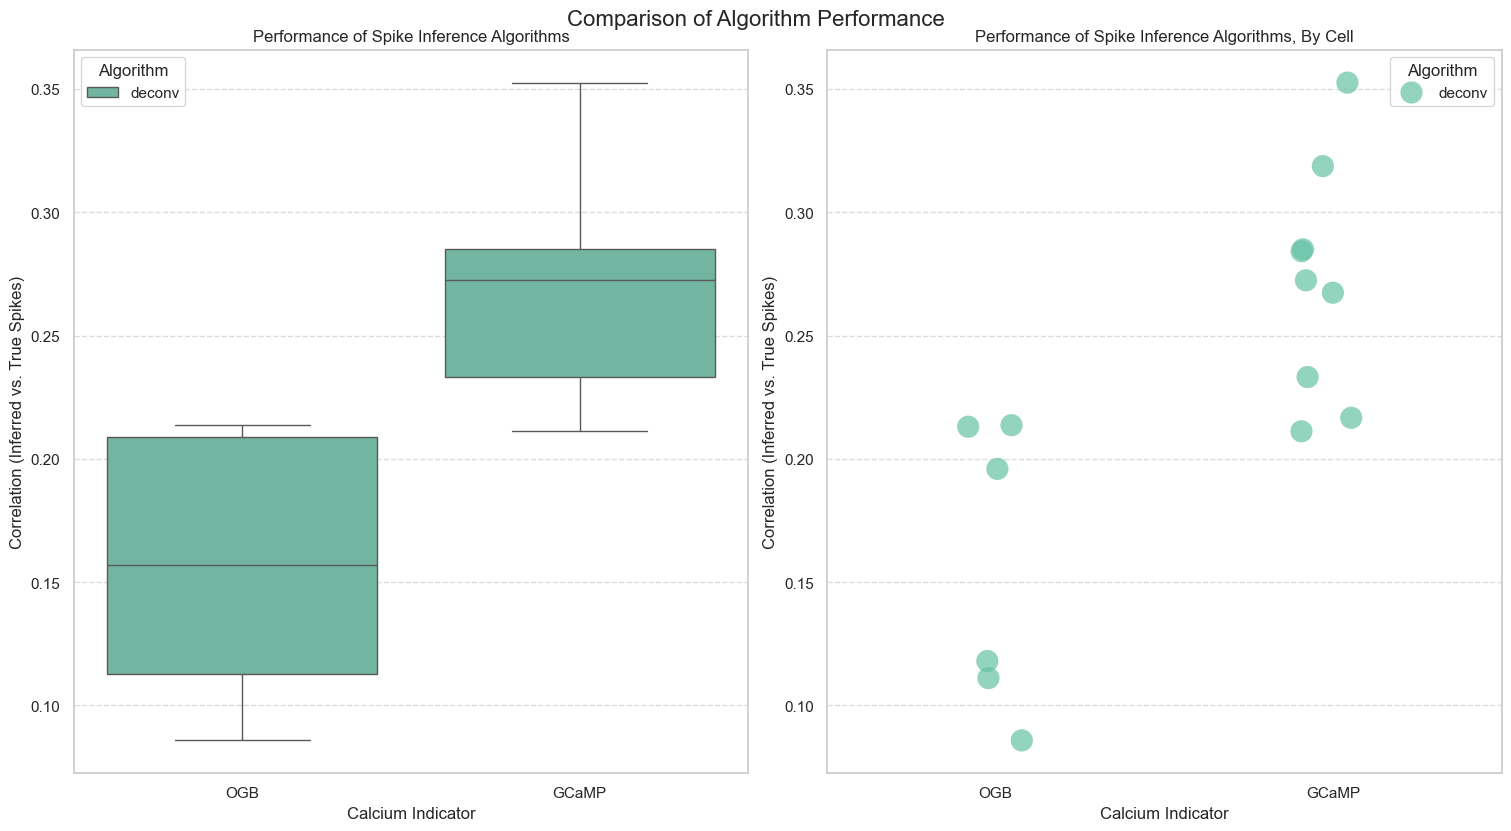

In [86]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

#fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")


#%%
# Create the figure and an array of Axes objects
fig, axes = plt.subplots(ncols=2, figsize=(15, 8), layout="constrained") # Renamed 'ax' to 'axes' for clarity

# Set an overall title for the entire figure (optional)
fig.suptitle("Comparison of Algorithm Performance", fontsize=16, y=1.02) # y positions suptitle slightly higher

# Call your plotting functions, passing the specific Axes object for each plot
# These functions are expected to set their own titles and legends.
box_plot_eval_results(axes[0], eval_results_df)
strip_plot_eval_results(axes[1], eval_results_df)

# Save the entire figure (which now contains two subplots)
plt.savefig("../plots/eval_results_comparison_plots.png", dpi=300) # Adjusted filename for clarity
plt.show()